In [2]:
# Deep learning 추천

import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [3]:
##### (1)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

# Variable 초기화
K = 200  # Latent factor 수
mu = ratings_train.rating.mean()  # 전체 평균
M = ratings.user_id.max() + 1  # Number of users
N = ratings.movie_id.max() + 1  # Number of movies


# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


##### (2)

# Keras model
user = Input(shape=(1,))  # User input
item = Input(shape=(1,))  # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)  # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)  # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(
    user
)  # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(
    item
)  # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation

P_embedding = Flatten()(P_embedding)  # (K, )
Q_embedding = Flatten()(Q_embedding)  # (K, )
user_bias = Flatten()(user_bias)  # (1, )
item_bias = Flatten()(item_bias)  # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])  # (2K + 2, )

# Neural network
R = Dense(2048)(R)
R = Activation("relu")(R)
R = Dense(256)(R)
R = Activation("linear")(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    # optimizer=Adamax(),
    metrics=[RMSE],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 200)               188800    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 200)               336600    ['input_2[0][0]']             
                                                                                              

In [4]:
# Model fitting
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    y=ratings_train.rating.values - mu,
    epochs=65,
    batch_size=512,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu,
    ),
)

Epoch 1/65
147/147 [==============================] - 5s 29ms/step - loss: 5.3930 - RMSE: 1.1276 - val_loss: 5.2578 - val_RMSE: 1.1177
Epoch 2/65
147/147 [==============================] - 3s 19ms/step - loss: 5.1484 - RMSE: 1.1264 - val_loss: 5.0205 - val_RMSE: 1.1168
Epoch 3/65
147/147 [==============================] - 3s 19ms/step - loss: 4.9177 - RMSE: 1.1253 - val_loss: 4.7967 - val_RMSE: 1.1160
Epoch 4/65
147/147 [==============================] - 3s 20ms/step - loss: 4.7003 - RMSE: 1.1244 - val_loss: 4.5857 - val_RMSE: 1.1150
Epoch 5/65
147/147 [==============================] - 3s 19ms/step - loss: 4.4954 - RMSE: 1.1238 - val_loss: 4.3866 - val_RMSE: 1.1142
Epoch 6/65
147/147 [==============================] - 3s 20ms/step - loss: 4.3020 - RMSE: 1.1229 - val_loss: 4.1990 - val_RMSE: 1.1133
Epoch 7/65
147/147 [==============================] - 3s 20ms/step - loss: 4.1196 - RMSE: 1.1218 - val_loss: 4.0219 - val_RMSE: 1.1123
Epoch 8/65
147/147 [==============================] - 3

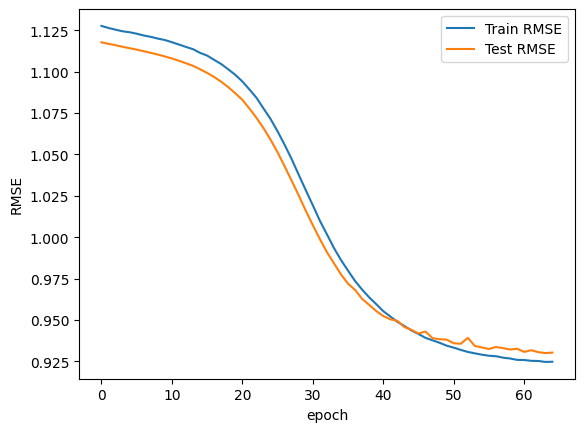

1/1 [==============================] - 0s 80ms/step
Actuals: 
        user_id  movie_id  rating
65234      897       928       5
28889      514         4       4
1354       210        97       5
45829      378       918       3
60788      308       661       4
54073      210       792       3

Predictions: 
 [[3.3770146]
 [3.5864022]
 [4.1249557]
 [3.036034 ]
 [4.1535926]
 [3.9717298]]
782/782 [==============================] - 1s 1ms/step


0.9308518055968963

In [5]:
# Plot RMSE
import matplotlib.pyplot as plt

plt.plot(result.history["RMSE"], label="Train RMSE")
plt.plot(result.history["val_RMSE"], label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)


# 정확도(RMSE)를 계산하는 함수
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))


user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order="C")
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)